In [45]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn import linear_model

Importing the data using read_csv


In [5]:
product_history = pd.read_csv("..\\data\\raw\\Historical Product Demand.csv")

Here we are just looking at some summary statistics. It looks like there are 33 unique product categories with 2160 unique products. The dates range from 2011 to 2017 and the mean order damand is ~5k, but median is just 300. This is a pretty straightforward data set as far as categories go. It doesn't look like we are going to have a lot of features in our model. Really, the only things that we will probably be using in oour models here are the product, category and demand. 


In [6]:
product_history.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


In [7]:
product_history["Date"] = pd.to_datetime(product_history["Date"])
product_history["Order_Demand"] = pd.to_numeric(product_history["Order_Demand"], errors="coerce")
product_history.describe()

,Order_Demand
count,1.038106e+06
mean,4.936488e+03
std,2.902462e+04
min,0.000000e+00
25%,2.000000e+01
50%,3.000000e+02
75%,2.000000e+03
max,4.000000e+06


In [8]:
product_history

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100.0
1,Product_0979,Whse_J,Category_028,2012-01-19,500.0
2,Product_0979,Whse_J,Category_028,2012-02-03,500.0
3,Product_0979,Whse_J,Category_028,2012-02-09,500.0
4,Product_0979,Whse_J,Category_028,2012-03-02,500.0
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000.0
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1.0
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500.0
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50.0


As you can see from the plot below, the distribution of order sizes is kind of interesting. There are a lot of small orders and some outliers where the order demand is orders of magnitude large. There are couple reasons that this could be the case. The first is that there are just some products that makke much more sense to be ordered in large size i.e. car vs charging cable. Another possibility is that there are just some customers that are ordering the same thing for very large size. Both of these are possible and could have implicaitons for possible predictions so we should be thinking about this when we make actual predicitions of future demand 

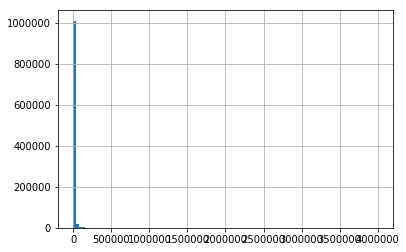

In [9]:
order_distribution = product_history.Order_Demand
order_distribution.hist(bins= 100)

In [10]:
product_history.index = product_history.Date

In [11]:
product_history = product_history.dropna()
product_history.sort_index()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
Date,,,,,
2011-01-08,Product_0965,Whse_A,Category_006,2011-01-08,2.0
2011-05-31,Product_1724,Whse_A,Category_003,2011-05-31,108.0
2011-06-24,Product_1521,Whse_S,Category_019,2011-06-24,85000.0
2011-06-24,Product_1521,Whse_S,Category_019,2011-06-24,7000.0
2011-09-02,Product_1507,Whse_C,Category_019,2011-09-02,1250.0
...,...,...,...,...,...
2017-01-06,Product_1710,Whse_J,Category_026,2017-01-06,15.0
2017-01-06,Product_1316,Whse_J,Category_019,2017-01-06,10000.0
2017-01-09,Product_0250,Whse_C,Category_007,2017-01-09,148.0


Looking at the products that have the most orders, these are probably the most most interesting/easiest to build prediction models. 

In [14]:
product_history.groupby("Product_Code").count().sort_values(by=["Warehouse"])

,Warehouse,Product_Category,Date,Order_Demand
Product_Code,,,,
Product_0853,1,1,1,1
Product_0465,1,1,1,1
Product_2099,1,1,1,1
Product_1703,1,1,1,1
Product_1698,2,2,2,2
...,...,...,...,...
Product_1286,8874,8874,8874,8874
Product_0620,9404,9404,9404,9404
Product_1378,9750,9750,9750,9750


Here we are looking at the total order demand every month for this product. It's really cool how easy it is to do this with groupby. Just from looking at this, there doesn't seem to be a whole lot of signal here. Things might be cyclical.

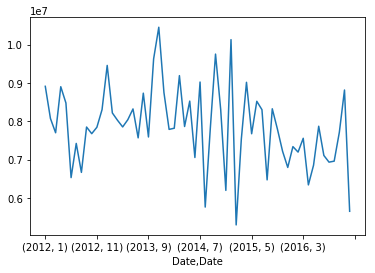

In [43]:
product = product_history[product_history["Product_Code"] == "Product_1359"]
product = product.groupby(by=[product.index.year,product.index.month]).sum()
product = product[:-1]
product["Order_Demand"].plot()

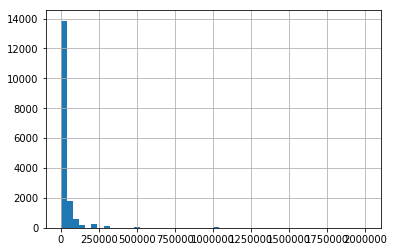

In [81]:
hist = product_history[product_history["Product_Code"] == "Product_1359"]
hist.Order_Demand.hist(bins = 50)

Using exponential smoothing here to predict the order demand for 1359 in the next month. This won't account for cycles in the data if they were to exist but it does give us some reasonable guess as to what future months of demand are for this product.

In [47]:
time_series = product["Order_Demand"]
fit = SimpleExpSmoothing(time_series, initialization_method="heuristic").fit(smoothing_level=0.2,optimized=False)

C:\Users\JohnQuitno\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


This gives us that the next month, January of  2017, will see a customer order demand of 7 million 

In [50]:
fit.forecast(1)

C:\Users\JohnQuitno\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


60    7.188777e+06
dtype: float64

We're going to do another prediction here using the exponential smoothing. This product looks a little more interesting just from the graph. It seems like there are some longer term trends here, the product's order  demand has gone up over the 4 years that are included here. Again, this looks kind of cyclical as well. It's like there are some yearly trends; you can see that there is a large spike in the graph roughly once every year.

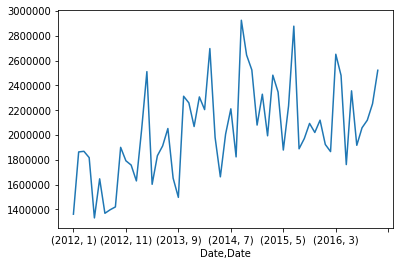

In [52]:
product1 = product_history[product_history["Product_Code"] == "Product_1295"]
product1 = product1.groupby(by=[product1.index.year,product1.index.month]).sum()
product1 = product1[:-1]
product1["Order_Demand"].plot()

In [56]:
time_series1 = product1["Order_Demand"]
fit1= SimpleExpSmoothing(time_series1, initialization_method="heuristic").fit(smoothing_level=0.2,optimized=False)

C:\Users\JohnQuitno\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Here we get that the order demand for the next month is 2.2 million

In [58]:
fit1.forecast(1)

C:\Users\JohnQuitno\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


59    2.218968e+06
dtype: float64

We're going to look at this same product again but this time use linear regression. This is the simplest of the forecasting models and won't be able to predic cycles again, however, this does catch overall trends. This should sitll give us a reasonable prediction for the future demand of this product based on historical trends. Just looking at the graph above it looks like there is some liner-ish relationship between time and order demand in the specific product.

In [69]:

time = []
for i in range(0, len(time_series1)):
    time.append([i])

In [76]:
reg = linear_model.LinearRegression()
reg.fit(time,time_series1)
time_coef = reg.coef_
intercept = reg.intercept_
next_month_pred = time_coef * 59 + intercept

The linear model gives a prediciont of 2.37 million for the next months order volume, this is similar to the exponential smoothing but slightly higher. This model should give us reasonable numbers for future values in this product too because of how it looks historically linear by nature.

In [77]:
next_month_pred

array([2373923.84570427])